<a href="https://colab.research.google.com/github/revak18/nicotine_use_mathmodel/blob/main/NicotineUse_SIR_DDE_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ddeint

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ddeint import ddeint

# Constants
B = 0.00103  # Birth rate per month
mu = 0.0006254  # Death rate per month
aging_rate_y_to_ya = 1 / (7 * 12) # 7 years to transition from 'youth' (11yrs) to 'young adult' (18yrs)
aging_rate_ya_to_a = 1 / (5 * 12)  # 5 years to transition from 'young adult' (18yrs)  to 'adult' (23yrs)


# tau_1: Delay for Infection (12 months)
tau_1 = 12
# Justification: The delay for infection (tau_1 = 12 months) reflects the time it might take for susceptible individuals
# to initiate Nicotine use. This delay can account for the gradual exposure to influencing factors like peer pressure,
# marketing, and social trends, which do not immediately result in uptake but may do so over an extended period.
# A year-long delay allows for these influences to accumulate and reflect realistic patterns seen in epidemiological studies
# of behavior adoption where repeated exposures increase the likelihood of adoption.

# tau_2:  Delay for Recovery (6 months)
tau_2 = 6
# How Long Does it Take to Break a Nicotine Addiction?
# https://www.urbanrecovery.com/blog/how-long-does-it-take-to-break-a-nicotine-addiction
# The recovery delay (tau_2 = 6 months) represents the time it might take for an individual to cease using nicotine products.
# Weeks 1-2	Physical withdrawal: During this period, the body adjusts to the absence of nicotine. Withdrawal symptoms are typically at their peak.

# Weeks 3-4	Psychological adjustments: As the physical withdrawal symptoms subside, individuals may still experience psychological cravings and triggers.
# This period focuses on addressing the psychological aspects of addiction.

# Months 1-6	Consolidating recovery: The cravings become less frequent and intense during this period. Individuals continue to refine coping strategies
# and adjust to life without nicotine.

# Beyond 6 Months	Maintaining a smoke-free life: After six months, many individuals experience a significant reduction in cravings and a sense of freedom
# from nicotine addiction. However, it's important to remain vigilant and continue implementing healthy habits to prevent relapse.


# tau_3: Delay for Relapse (12 months)
tau_3 = 12
# Stages of Change Theory: https://www.ncbi.nlm.nih.gov/books/NBK556005/
# "A longitudinal study from the 1990 Surgeon General's Report showed that after 12 months of abstinence, 43% of people returned to their smoking habit."

In [ ]:
import numpy as np
import random

#########################################
# beta: Infection coefficient
#########################################
# "If one of your best friends offered you a cigarette, would you smoke it?"
#  For e-cigarettes, 18% responded "yes" - 2016 U.S. Surgeon General report
#  For cigarettes, 0.3% responded "yes" - 2014 National Survey on Drug Use and Health
#  Calculates beta using "18%" & flg="EC"(e-cigarettes) OR 3% & flg="C"(cigarettes) as seed and seasonal variation.

def beta(t, flg):
  if flg == 'EC':
     beta = 0.18 + (random.random()/100) * np.cos(t / 12 * np.pi)
  else:
     beta = 0.003 + (random.random()/1000) * np.cos(t / 12 * np.pi)
  return beta


#########################################
# gamma: Recovery coefficients
#########################################
# Smoking Cessation: Fast Facts
# https://www.cdc.gov/tobacco/php/data-statistics/smoking-cessation/index.html
# In 2022, 67.7% of adults who smoked said they wanted to quit smoking.

# Quitting e-cigarettes: Quit attempts and quit intentions among youth and young adults
# https://pmc.ncbi.nlm.nih.gov/articles/PMC7808959/#:~:text=3.2.-,Cessation%20outcomes,reported%20general%20intentions%20to%20quit.
# Among current e-cigarette users, 33.3% reported a past-year quit attempt

# Calculates gamma using "33.30%" & flg="EC"(e-cigarettes) OR 67.70% & flg="C"(cigarettes) as seed and seasonal variation.
def gamma(t, flg):
  if flg == 'EC':
     gamma = (1.333 **(1/12) - 1) + (random.random()/100) * np.cos(t / 12 * np.pi) #e-cigarettes
  else:
     gamma = (1.677 **(1/12) - 1) + (random.random()/100) * np.cos(t / 12 * np.pi) #cigarettes
  return gamma


#########################################
# rho: Relapse coefficients
#########################################
# Smoking Cessation: Fast Facts
# https://www.cdc.gov/tobacco/php/data-statistics/smoking-cessation/index.html
# In 2022, 8.8% of adults who smoked were able to successfully quit smoking in the past year.
# That means 100 - 8.8 = 91.2% relapsed.

# Effectiveness of e-cigarettes as aids for smoking cessation: evidence from the PATH Study cohort, 2017–2019
# https://tobaccocontrol.bmj.com/content/32/e2/e145
# Furthermore, switching to e-cigarettes did not reduce the risk of relapse to cigarette smoking compared with other recent former smokers.
# Instead, nearly 60% of recent former smokers who were daily e-cigarette users had relapsed to cigarette smoking by 2019 (W5).

# Calculates rho using "60.00%" & flg="EC"(e-cigarettes) OR 91.20% & flg="C"(cigarettes) as seed and seasonal variation.
def rho(t, flg):
  if flg == 'EC':
     rho = (1.600 **(1/12) - 1) + (random.random()/100) * np.cos(t / 12 * np.pi) #e-cigarettes
  else:
     rho = (1.912 **(1/12) - 1) + (random.random()/100) * np.cos(t / 12 * np.pi) #cigarettes
  return rho

In [ ]:
def model(Y, t):

    S_y, I_y, R_y, S_ya, I_ya, R_ya, S_a, I_a, R_a = Y(t)

    # Accessing delayed values using indexing
    if t >= tau_1:
        S_y_delay = Y(t - tau_1)[0]
        I_y_delay = Y(t - tau_1)[1]
        R_y_delay = Y(t - tau_1)[2]
    else:
        S_y_delay, I_y_delay, R_y_delay = S_y, I_y, R_y

    if t >= tau_2:
        I_y_delay2 = Y(t - tau_2)[1]
    else:
        I_y_delay2 = I_y

    if t >= tau_3:
        R_y_delay3 = Y(t - tau_3)[2]
    else:
        R_y_delay3 = R_y

    t = int(t)

    # Population dynamics
    dS_y_dt = B - beta[t] * S_y * I_y_delay - mu * S_y - aging_rate_y_to_ya * S_y
    dI_y_dt = beta[t] * S_y * I_y_delay - (mu + gamma[t]) * I_y_delay2 + rho[t] * R_y_delay3 - aging_rate_y_to_ya * I_y
    dR_y_dt = gamma[t] * I_y_delay2 - (mu + rho[t]) * R_y - aging_rate_y_to_ya * R_y

    dS_ya_dt = S_y * aging_rate_y_to_ya - beta[t] * S_ya * I_ya - mu * S_ya - aging_rate_ya_to_a * S_ya
    dI_ya_dt = I_y * aging_rate_y_to_ya + beta[t]* S_ya * I_ya - (mu + gamma[t]) * I_ya - aging_rate_ya_to_a * I_ya
    dR_ya_dt = R_y * aging_rate_y_to_ya + gamma[t] * I_ya - (mu + rho[t]) * R_ya - aging_rate_ya_to_a * R_ya

    dS_a_dt = S_ya * aging_rate_ya_to_a - beta[t] * S_a * I_a - mu * S_a
    dI_a_dt = I_ya * aging_rate_ya_to_a + beta[t] * S_a * I_a - (mu + gamma[t]) * I_a
    dR_a_dt = R_ya * aging_rate_ya_to_a + gamma[t] * I_a - (mu + rho[t]) * R_a

    return [dS_y_dt, dI_y_dt, dR_y_dt, dS_ya_dt, dI_ya_dt, dR_ya_dt, dS_a_dt, dI_a_dt, dR_a_dt]

def history(t):
    if product_type == 'EC':    # E-Cigarettes
       return [0.7530, 0.2470, 0.0000, 0.9400, 0.0600, 0.0000, 0.9400, 0.0600, 0.0000]  # Initial values for E-cigarettes all states of Youth, Young Adults and Adults
    else:    # Cigarettes
       return [0.9250, 0.0750, 0.0000, 0.8840, 0.1160, 0.0000, 0.8840, 0.1160, 0.0000]  # Initial values for Cigarettes all states of Youth, Young Adults and Adults

# Solve DDE
t = np.linspace(0, 120, 120)  # Simulate for 10 years
t = t.astype('int32')
sol = ddeint(model, history, t)

totals = sol.sum(axis=1)
sol /= totals[:, None]

# **FINAL CODE DO NOT DELETE**

**1**

In [10]:
!pip install ddeint

**2**

In [16]:
import numpy as np
import random
import matplotlib.pyplot as plt
from ddeint import ddeint

# Constants
B = 0.00103  # Birth rate per month
mu = 0.0006254  # Death rate per month
aging_rate_y_to_ya = 1 / (7 * 12)  # Years to transition from youth to young adult
aging_rate_ya_to_a = 1 / (5 * 12)  # Years to transition from young adult to adult
tau_1, tau_2, tau_3 = 12, 6, 12  # Delays for infection, recovery, and relapse

# Seed for reproducibility
random.seed(42)
np.random.seed(42)

# Function to generate linearly spaced integers
def linspace_integers(start, stop, num):
    """Generate a linearly spaced array of integers."""
    step = (stop - start) // (num - 1)  # Calculate step using integer division
    return np.arange(start, stop + step, step, dtype=int)

# Generate time points
t = linspace_integers(0, 419, 420)

# Product type for simulation
product_type = 'C'  # Change to 'C' for cigarettes

# Function to calculate beta values
def beta_values(t):
    """Calculate beta values depending on the product type."""
    if product_type == 'EC':
        return 0.18 + (random.random() / 100) * np.cos(t / 12 * np.pi)
    else:
        return 0.003 + (random.random() / 1000) * np.cos(t / 12 * np.pi)

# Function to calculate gamma values
def gamma_values(t):
    """Calculate gamma values depending on the product type."""
    if product_type == 'EC':
        return (1.333 ** (1 / 12) - 1) + (random.random() / 100) * np.cos(t / 12 * np.pi)
    else:
        return (1.677 ** (1 / 12) - 1) + (random.random() / 100) * np.cos(t / 12 * np.pi)

# Function to calculate rho values
def rho_values(t):
    """Calculate rho values depending on the product type."""
    if product_type == 'EC':
        return (1.600 ** (1 / 12) - 1) + (random.random() / 100) * np.cos(t / 12 * np.pi)
    else:
        return (1.912 ** (1 / 12) - 1) + (random.random() / 100) * np.cos(t / 12 * np.pi)

# Calculate parameter arrays
beta = np.array([beta_values(t_i) for t_i in t])
gamma = np.array([gamma_values(t_i) for t_i in t])
rho = np.array([rho_values(t_i) for t_i in t])

# Output the first calculated value for beta, gamma, and rho for verification
print("First beta value:", beta[0])
print("First gamma value:", gamma[0])
print("First rho value:", rho[0])

First beta value: 0.003639426798457884
First gamma value: 0.04816986743081948
First rho value: 0.05888339183070972


**3**

In [17]:
def model(Y, t):
    S_y, I_y, R_y, S_ya, I_ya, R_ya, S_a, I_a, R_a = Y(t)

    # Accessing delayed values using indexing
    if t >= tau_1:
        S_y_delay = Y(t - tau_1)[0]
        I_y_delay = Y(t - tau_1)[1]
    else:
        S_y_delay = S_y
        I_y_delay = I_y

    if t >= tau_2:
        I_y_delay2 = Y(t - tau_2)[1]
        I_ya_delay2 = Y(t - tau_2)[4]
        I_a_delay2 = Y(t - tau_2)[7]
    else:
        I_y_delay2 = I_y
        I_ya_delay2 = I_ya
        I_a_delay2 = I_a

    if t >= tau_3:
        R_y_delay3 = Y(t - tau_3)[2]
        R_ya_delay3 = Y(t - tau_3)[5]
        R_a_delay3 = Y(t - tau_3)[8]
    else:
        R_y_delay3 = R_y
        R_ya_delay3 = R_ya
        R_a_delay3 = R_a

    t = int(t)

    # Population dynamics
    dS_y_dt = B - beta[t] * S_y * I_y_delay - mu * S_y - aging_rate_y_to_ya * S_y
    dI_y_dt = beta[t] * S_y * I_y_delay - (mu + gamma[t]) * I_y + rho[t] * R_y_delay3 - aging_rate_y_to_ya * I_y
    dR_y_dt = gamma[t] * I_y_delay2 - (mu + rho[t]) * R_y - aging_rate_y_to_ya * R_y

    dS_ya_dt = S_y * aging_rate_y_to_ya - beta[t] * S_ya * I_y_delay - mu * S_ya - aging_rate_ya_to_a * S_ya
    dI_ya_dt = I_y * aging_rate_y_to_ya + beta[t] * S_ya * I_y_delay - (mu + gamma[t]) * I_ya - aging_rate_ya_to_a * I_ya
    dR_ya_dt = R_y * aging_rate_y_to_ya + gamma[t] * I_ya_delay2 - (mu + rho[t]) * R_ya_delay3 - aging_rate_ya_to_a * R_ya

    dS_a_dt = S_ya * aging_rate_ya_to_a - beta[t] * S_a * I_a - mu * S_a
    dI_a_dt = I_ya * aging_rate_ya_to_a + beta[t] * S_a * I_a - (mu + gamma[t]) * I_a_delay2
    dR_a_dt = R_ya * aging_rate_ya_to_a + gamma[t] * I_a_delay2 - (mu + rho[t]) * R_a_delay3

    return [dS_y_dt, dI_y_dt, dR_y_dt, dS_ya_dt, dI_ya_dt, dR_ya_dt, dS_a_dt, dI_a_dt, dR_a_dt]

def history(t):
    if product_type == 'EC':    # E-Cigarettes
       return [0.7530, 0.2470, 0.0000, 0.9400, 0.0600, 0.0000, 0.9400, 0.0600, 0.0000]  # Initial values for E-cigarettes all states of Youth, Young Adults and Adults
    else:    # Cigarettes
       return [0.9250, 0.0750, 0.0000, 0.8840, 0.1160, 0.0000, 0.8840, 0.1160, 0.0000]  # Initial values for Cigarettes all states of Youth, Young Adults and Adults

# Solve DDE
t = np.linspace(0, 120, 120)  # Simulate for 10 years
t = t.astype('int32')
sol = ddeint(model, history, t)

totals = sol.sum(axis=1)
sol /= totals[:, None]

**4**

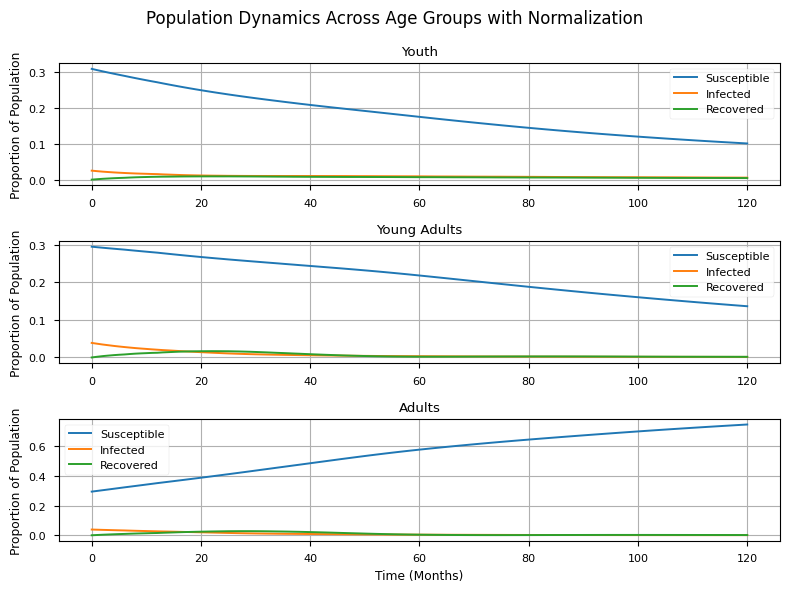

In [18]:
# Plotting results
plt.figure(figsize=(8, 6))
# Subplot for Youth
plt.subplot(3, 1, 1)
plt.plot(t, sol[:, 0], label='Susceptible')
plt.plot(t, sol[:, 1], label='Infected')
plt.plot(t, sol[:, 2], label='Recovered')
plt.title('Youth')
plt.ylabel('Proportion of Population')
plt.legend()
plt.grid(True)

# Subplot for Young Adults
plt.subplot(3, 1, 2)
plt.plot(t, sol[:, 3], label='Susceptible')
plt.plot(t, sol[:, 4], label='Infected')
plt.plot(t, sol[:, 5], label='Recovered')
plt.title('Young Adults')
plt.ylabel('Proportion of Population')
plt.legend()
plt.grid(True)

# Subplot for Adults
plt.subplot(3, 1, 3)
plt.plot(t, sol[:, 6], label='Susceptible')
plt.plot(t, sol[:, 7], label='Infected')
plt.plot(t, sol[:, 8], label='Recovered')
plt.title('Adults')
plt.xlabel('Time (Months)')
plt.ylabel('Proportion of Population')
plt.legend()
plt.grid(True)

plt.suptitle('Population Dynamics Across Age Groups with Normalization')
plt.tight_layout()
plt.show()

**4A**

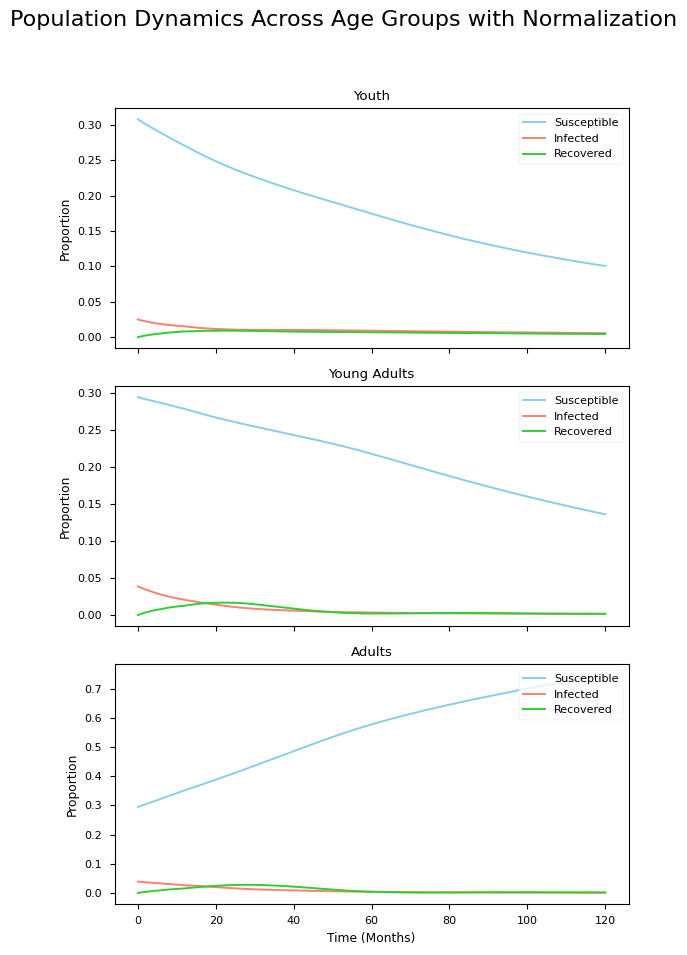

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 't' and 'sol' are defined as per your model output
# Example data (uncomment and modify according to your actual 't' and 'sol' variables)
# t = np.linspace(0, 120, 120)
# sol = np.random.rand(120, 9)  # Simulated solution for demonstration

# Use a built-in style
plt.style.use('seaborn-v0_8-paper')  # or 'ggplot', 'seaborn-poster', etc., based on preference

#['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background',
#'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind',
#'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook',
#'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


# Set up figure and axes
fig, axs = plt.subplots(3, 1, figsize=(6, 10), sharex=True)  # Share X-axis

# Titles for each subplot
titles = ['Youth', 'Young Adults', 'Adults']
labels = ['Susceptible', 'Infected', 'Recovered']
colors = ['skyblue', 'salmon', 'limegreen']  # Colors for each line

for i in range(3):
    ax = axs[i]
    for j in range(3):
        ax.plot(t, sol[:, i*3 + j], label=labels[j], color=colors[j])
    ax.set_title(titles[i])
    ax.set_ylabel('Proportion')
    ax.legend(frameon=True, loc='upper right')
    if i == 2:
        ax.set_xlabel('Time (Months)')

fig.suptitle('Population Dynamics Across Age Groups with Normalization', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the rect to leave space for suptitle

plt.show()


**5**

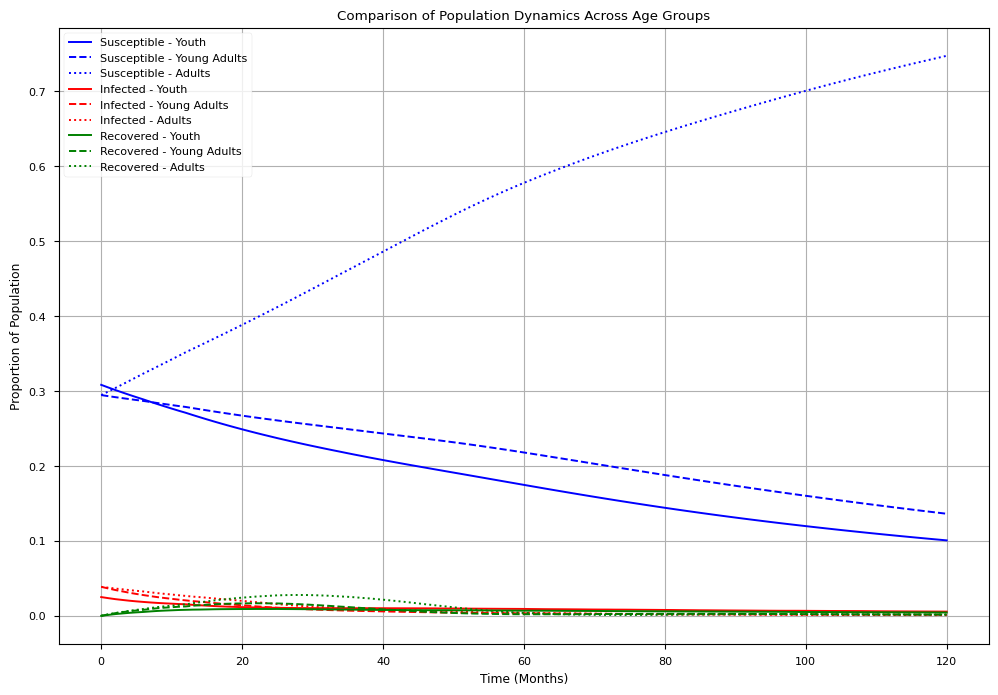

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 't' and 'sol' are defined as per your model output
# t = np.linspace(0, 120, 120)  # Time array
# sol = np.random.rand(120, 9)  # Solution array with different compartments

plt.figure(figsize=(12, 8))
states = ['Susceptible', 'Infected', 'Recovered']
colors = ['blue', 'red', 'green']

# Plotting each state for all age groups
for i, state in enumerate(states):
    plt.plot(t, sol[:, i], label=f'{state} - Youth', color=colors[i], linestyle='-')
    plt.plot(t, sol[:, i + 3], label=f'{state} - Young Adults', color=colors[i], linestyle='--')
    plt.plot(t, sol[:, i + 6], label=f'{state} - Adults', color=colors[i], linestyle=':')

plt.title('Comparison of Population Dynamics Across Age Groups')
plt.xlabel('Time (Months)')
plt.ylabel('Proportion of Population')
plt.legend()
plt.grid(True)
plt.show()


# **Testing Potential Enahancements to Final Code version**

**Sensitivity Analysis**

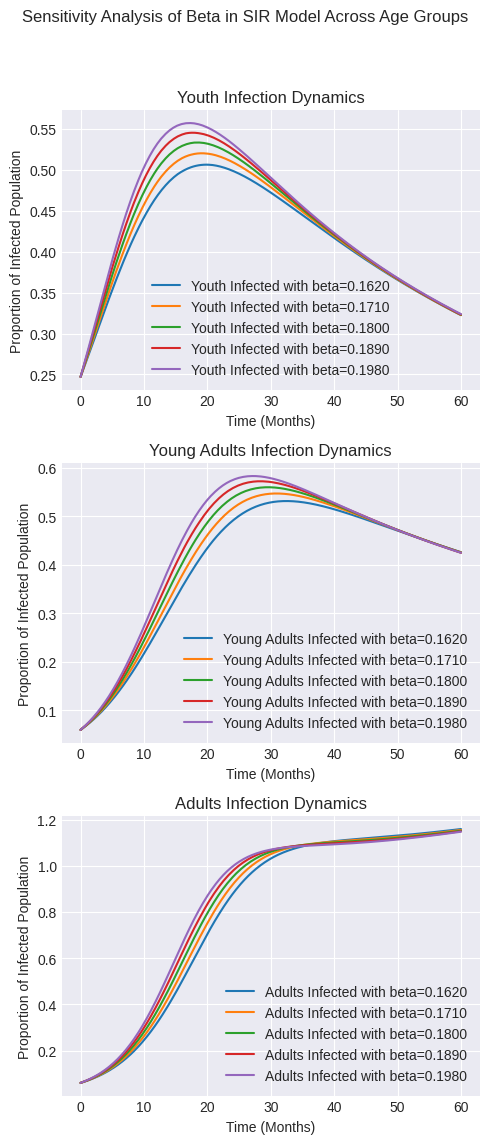

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ddeint import ddeint

# Constants
B = 0.00103  # Birth rate per month
mu = 0.0006254  # Death rate per month
aging_rate_y_to_ya = 1 / (7 * 12)  # Transition rate from youth to young adults
aging_rate_ya_to_a = 1 / (5 * 12)  # Transition rate from young adults to adults
tau_1, tau_2, tau_3 = 12, 6, 12  # Delays for infection, recovery, and relapse processes

# Base rates for E-cigarettes
base_gamma = 0.0242  # Recovery rate
base_rho = 0.040  # Relapse rate
base_beta = 0.18  # Base infection rate for E-cigarettes

# Variation range
variation = 0.10

# Define parameter variations
beta_values = base_beta * (1 + np.linspace(-variation, variation, 5))
gamma_values = base_gamma * (1 + np.linspace(-variation, variation, 5))
rho_values = base_rho * (1 + np.linspace(-variation, variation, 5))

# Model definition
def model(Y, t, beta, gamma, rho):
    # Unpack current values
    S_y, I_y, R_y, S_ya, I_ya, R_ya, S_a, I_a, R_a = Y(t)

    # Dynamics for all three age groups
    # Youth
    dS_y_dt = B - beta * S_y * I_y - mu * S_y - aging_rate_y_to_ya * S_y
    dI_y_dt = beta * S_y * I_y - (mu + gamma) * I_y + rho * R_y - aging_rate_y_to_ya * I_y
    dR_y_dt = gamma * I_y - (mu + rho) * R_y - aging_rate_y_to_ya * R_y

    # Young Adults
    dS_ya_dt = aging_rate_y_to_ya * S_y - beta * S_ya * I_ya - mu * S_ya - aging_rate_ya_to_a * S_ya
    dI_ya_dt = aging_rate_y_to_ya * I_y + beta * S_ya * I_ya - (mu + gamma) * I_ya + rho * R_ya - aging_rate_ya_to_a * I_ya
    dR_ya_dt = aging_rate_y_to_ya * R_y + gamma * I_ya - (mu + rho) * R_ya - aging_rate_ya_to_a * R_ya

    # Adults
    dS_a_dt = aging_rate_ya_to_a * S_ya - beta * S_a * I_a - mu * S_a
    dI_a_dt = aging_rate_ya_to_a * I_ya + beta * S_a * I_a - (mu + gamma) * I_a + rho * R_a
    dR_a_dt = aging_rate_ya_to_a * R_ya + gamma * I_a - (mu + rho) * R_a

    return [dS_y_dt, dI_y_dt, dR_y_dt, dS_ya_dt, dI_ya_dt, dR_ya_dt, dS_a_dt, dI_a_dt, dR_a_dt]

# Initial conditions function
def history(t):
    # Initial conditions for all groups
    #return np.array([0.9250, 0.0750, 0.0000, 0.8840, 0.1160, 0.0000, 0.8840, 0.1160, 0.0000]) # Initial values for Cigarettes all states of Youth, Young Adults and Adults
    return np.array([0.7530, 0.2470, 0.0000, 0.9400, 0.0600, 0.0000, 0.9400, 0.0600, 0.0000])  # Initial values for E-cigarettes all states of Youth, Young Adults and Adults


# Solve the DDE for different beta values
t = np.linspace(0, 60, 600)  # Simulation over 10 years
results = {}

for beta in beta_values:
    sol = ddeint(lambda Y, t: model(Y, t, beta, base_gamma, base_rho), history, t)
    results[beta] = sol


#totals = sol.sum(axis=1)
#sol /= totals[:, None]



# Plotting the results for each group
fig, axs = plt.subplots(3, 1, figsize=(5, 12))
fig.suptitle('Sensitivity Analysis of Beta in SIR Model Across Age Groups')

# Plot for each beta across groups
for beta, sol in results.items():
    axs[0].plot(t, sol[:, 1], label=f'Youth Infected with beta={beta:.4f}')
    axs[1].plot(t, sol[:, 4], label=f'Young Adults Infected with beta={beta:.4f}')
    axs[2].plot(t, sol[:, 7], label=f'Adults Infected with beta={beta:.4f}')

# Adding labels and legends
for i, age_group in enumerate(['Youth', 'Young Adults', 'Adults']):
    axs[i].set_title(f'{age_group} Infection Dynamics')
    axs[i].set_xlabel('Time (Months)')
    axs[i].set_ylabel('Proportion of Infected Population')
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
